# Deep Q Learning Mountain Car

In [2]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using Flux
using Flux: params
using Plots; gr(); 
import StatsBase.sample

env = MountainCarEnv();

Firstly, we will define agent's "brain". It will be a struct storing a neural network model and all necessary learning parameters:

In [3]:
mutable struct Brain
    β::Float64
    batch_size::Int
    memory_size::Int
    min_memory_size::Int
    memory::Array{Tuple,1}
    net::Chain
    η::Float64
    opt_state::NamedTuple
end

function Brain(env; β = 0.99, η = 0.001)
    model = Chain(Dense(length(env.state), 128, relu), 
            Dense(128, 52, relu), 
            Dense(52, length(action_space(env)), identity))
    opt_state = Flux.setup(Adam(η), model) 
    Brain(β, 64 , 50_000, 1000, [], model, η, opt_state)
end

Brain

and the loss functions:

In [4]:
loss(m, x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

Then Agent:

In [5]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64
    ϵ_decay::Float64
    ϵ_min::Float64
    brain::Brain
    position::Float64
    reward::Float64
end

Agent(env::AbstractEnv, ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005) = Agent(env, ϵ, ϵ_decay, ϵ_min, 
                                                                        Brain(env), -Inf, 0.0)

Agent

Finally, functions that control the learning process:

In [6]:
function replay!(agent::Agent)
    x = zeros(Float32,length(agent.env.state), agent.brain.batch_size)
    y = zeros(Float32,length(action_space(agent.env)), agent.brain.batch_size)
    for (i,step)  in enumerate(sample(agent.brain.memory, agent.brain.batch_size, replace = false))
        s,a,r,s′,terminal = step
        terminal ? (R  = r) : (R = r + agent.brain.β * maximum(agent.brain.net(s′)))
        Q = agent.brain.net(s)
        Q[a] = R
        x[:, i] .= s
        y[:, i] .= Q
    end
    Flux.train!(loss, agent.brain.net, [(x, y)], agent.brain.opt_state)
end

replay! (generic function with 1 method)

In [7]:
function remember!(brain::Brain, step::Tuple)
    length(brain.memory) == brain.memory_size && deleteat!(brain.memory,1)
    push!(brain.memory, step)
end

remember! (generic function with 1 method)

In [8]:
policy(agent::Agent, state::Array{Float64,1}) = argmax(agent.brain.net(Float32.(state)))

policy (generic function with 1 method)

In [9]:
function step!(agent::Agent, train::Bool)
    s = deepcopy(agent.env.state)
    (rand() < agent.ϵ  && train) ? (a = rand(action_space(agent.env))) : (a = policy(agent, s))
    act!(agent.env, a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)),
    deepcopy(is_terminated(agent.env))
    agent.position = s′[1]
    agent.reward += r
    remember!(agent.brain, (s,a,r,s′,terminal))
    (train && length(agent.brain.memory) > agent.brain.min_memory_size) && replay!(agent)
    terminal 
end

step! (generic function with 1 method)

In [10]:
function run!(agent::Agent, episodes::Int; train::Bool = true, plotting::Bool = true, summary::Bool = true)
    rewards = []
    success_rates = []
    ep = 1.0
    success = 0.0
    while ep ≤ episodes
        plotting && (plot(agent.env); sleep(0.0001))
        if step!(agent, train) 
            reset!(agent.env)
            agent.position > 0.5 && (success += 1.0)
            push!(rewards, agent.reward)
            push!(success_rates, success/ep)
            if summary
                println("episode $(Int(ep)) ends! Reward: $(agent.reward)")
                println("ϵ: $(agent.ϵ), success rate: $(success/ep)")
            end
            ep += 1.0
            agent.reward = 0.0
            agent.position = -Inf
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
        end
    end
    return rewards, success_rates
end

run! (generic function with 1 method)

## Experiment

In [11]:
agent = Agent(env);

Before Learning:

In [12]:
#rewards,_ = run!(agent,10; train = false, plotting = true);

After Learning:

In [13]:
rewards, success_rates = run!(agent,1000; plotting = false);
#rewards,_ = run!(agent,10; train = false, plotting = true);

episode 1 ends! Reward: -199.0
ϵ: 1.0, success rate: 0.0
episode 2 ends! Reward: -199.0
ϵ: 0.9975, success rate: 0.0
episode 3 ends! Reward: -199.0
ϵ: 0.9950062500000001, success rate: 0.0
episode 4 ends! Reward: -199.0
ϵ: 0.9925187343750002, success rate: 0.0
episode 5 ends! Reward: -199.0
ϵ: 0.9900374375390627, success rate: 0.0


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 128, relu)  # 384 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\htpCe\src\layers\stateless.jl:59


episode 6 ends! Reward: -199.0
ϵ: 0.9875623439452151, success rate: 0.0
episode 7 ends! Reward: -199.0
ϵ: 0.9850934380853521, success rate: 0.0
episode 8 ends! Reward: -199.0
ϵ: 0.9826307044901388, success rate: 0.0
episode 9 ends! Reward: -199.0
ϵ: 0.9801741277289134, success rate: 0.0
episode 10 ends! Reward: -199.0
ϵ: 0.9777236924095912, success rate: 0.0
episode 11 ends! Reward: -199.0
ϵ: 0.9752793831785673, success rate: 0.0
episode 12 ends! Reward: -199.0
ϵ: 0.972841184720621, success rate: 0.0
episode 13 ends! Reward: -199.0
ϵ: 0.9704090817588195, success rate: 0.0
episode 14 ends! Reward: -199.0
ϵ: 0.9679830590544225, success rate: 0.0
episode 15 ends! Reward: -199.0
ϵ: 0.9655631014067865, success rate: 0.0
episode 16 ends! Reward: -199.0
ϵ: 0.9631491936532696, success rate: 0.0
episode 17 ends! Reward: -199.0
ϵ: 0.9607413206691364, success rate: 0.0
episode 18 ends! Reward: -199.0
ϵ: 0.9583394673674637, success rate: 0.0
episode 19 ends! Reward: -199.0
ϵ: 0.9559436186990451, s

episode 446 ends! Reward: -199.0
ϵ: 0.3282784994873863, success rate: 0.0
episode 447 ends! Reward: -199.0
ϵ: 0.32745780323866785, success rate: 0.0
episode 448 ends! Reward: -199.0
ϵ: 0.3266391587305712, success rate: 0.0
episode 449 ends! Reward: -199.0
ϵ: 0.3258225608337448, success rate: 0.0
episode 450 ends! Reward: -199.0
ϵ: 0.32500800443166045, success rate: 0.0
episode 451 ends! Reward: -199.0
ϵ: 0.3241954844205813, success rate: 0.0
episode 452 ends! Reward: -199.0
ϵ: 0.3233849957095299, success rate: 0.0
episode 453 ends! Reward: -199.0
ϵ: 0.3225765332202561, success rate: 0.0
episode 454 ends! Reward: -199.0
ϵ: 0.32177009188720546, success rate: 0.0
episode 455 ends! Reward: -199.0
ϵ: 0.32096566665748744, success rate: 0.0
episode 456 ends! Reward: -199.0
ϵ: 0.3201632524908437, success rate: 0.0
episode 457 ends! Reward: -199.0
ϵ: 0.3193628443596166, success rate: 0.0
episode 458 ends! Reward: -199.0
ϵ: 0.3185644372487176, success rate: 0.0
episode 459 ends! Reward: -199.0
ϵ

ϵ: 0.25240467659884375, success rate: 0.0018148820326678765
episode 552 ends! Reward: -199.0
ϵ: 0.25177366490734665, success rate: 0.0018115942028985507
episode 553 ends! Reward: -199.0
ϵ: 0.2511442307450783, success rate: 0.0018083182640144665
episode 554 ends! Reward: -199.0
ϵ: 0.2505163701682156, success rate: 0.0018050541516245488
episode 555 ends! Reward: -199.0
ϵ: 0.24989007924279508, success rate: 0.0018018018018018018
episode 556 ends! Reward: -199.0
ϵ: 0.2492653540446881, success rate: 0.0017985611510791368
episode 557 ends! Reward: -199.0
ϵ: 0.2486421906595764, success rate: 0.0017953321364452424
episode 558 ends! Reward: -199.0
ϵ: 0.24802058518292747, success rate: 0.0017921146953405018
episode 559 ends! Reward: -199.0
ϵ: 0.24740053371997017, success rate: 0.0017889087656529517
episode 560 ends! Reward: -199.0
ϵ: 0.24678203238567026, success rate: 0.0017857142857142857
episode 561 ends! Reward: -199.0
ϵ: 0.2461650773047061, success rate: 0.0017825311942959
episode 562 ends! 

episode 641 ends! Reward: -199.0
ϵ: 0.20149245557815434, success rate: 0.0015600624024961
episode 642 ends! Reward: -199.0
ϵ: 0.20098872443920898, success rate: 0.001557632398753894
episode 643 ends! Reward: -199.0
ϵ: 0.20048625262811098, success rate: 0.0015552099533437014
episode 644 ends! Reward: -199.0
ϵ: 0.19998503699654072, success rate: 0.0015527950310559005
episode 645 ends! Reward: -199.0
ϵ: 0.19948507440404936, success rate: 0.0015503875968992248
episode 646 ends! Reward: -199.0
ϵ: 0.19898636171803924, success rate: 0.0015479876160990713
episode 647 ends! Reward: -199.0
ϵ: 0.19848889581374415, success rate: 0.0015455950540958269
episode 648 ends! Reward: -199.0
ϵ: 0.1979926735742098, success rate: 0.0015432098765432098
episode 649 ends! Reward: -199.0
ϵ: 0.19749769189027427, success rate: 0.0015408320493066256
episode 650 ends! Reward: -199.0
ϵ: 0.1970039476605486, success rate: 0.0015384615384615385
episode 651 ends! Reward: -199.0
ϵ: 0.19651143779139724, success rate: 0.001

ϵ: 0.1612528048549283, success rate: 0.03561643835616438
episode 731 ends! Reward: -113.0
ϵ: 0.16084967284279097, success rate: 0.036935704514363885
episode 732 ends! Reward: -154.0
ϵ: 0.160447548660684, success rate: 0.03825136612021858
episode 733 ends! Reward: -199.0
ϵ: 0.1600464297890323, success rate: 0.03819918144611187
episode 734 ends! Reward: -147.0
ϵ: 0.15964631371455973, success rate: 0.039509536784741145
episode 735 ends! Reward: -116.0
ϵ: 0.15924719793027334, success rate: 0.04081632653061224
episode 736 ends! Reward: -139.0
ϵ: 0.15884907993544767, success rate: 0.042119565217391304
episode 737 ends! Reward: -139.0
ϵ: 0.15845195723560906, success rate: 0.04341926729986431
episode 738 ends! Reward: -142.0
ϵ: 0.15805582734252005, success rate: 0.044715447154471545
episode 739 ends! Reward: -144.0
ϵ: 0.15766068777416375, success rate: 0.046008119079837616
episode 740 ends! Reward: -134.0
ϵ: 0.15726653605472835, success rate: 0.0472972972972973
episode 741 ends! Reward: -185.0

episode 822 ends! Reward: -163.0
ϵ: 0.12808388103885365, success rate: 0.13990267639902676
episode 823 ends! Reward: -146.0
ϵ: 0.12776367133625652, success rate: 0.14094775212636695
episode 824 ends! Reward: -145.0
ϵ: 0.12744426215791588, success rate: 0.14199029126213591
episode 825 ends! Reward: -173.0
ϵ: 0.1271256515025211, success rate: 0.14303030303030304
episode 826 ends! Reward: -150.0
ϵ: 0.1268078373737648, success rate: 0.1440677966101695
episode 827 ends! Reward: -136.0
ϵ: 0.1264908177803304, success rate: 0.14510278113663846
episode 828 ends! Reward: -144.0
ϵ: 0.12617459073587958, success rate: 0.1461352657004831
episode 829 ends! Reward: -146.0
ϵ: 0.1258591542590399, success rate: 0.1471652593486128
episode 830 ends! Reward: -152.0
ϵ: 0.12554450637339232, success rate: 0.14819277108433734
episode 831 ends! Reward: -149.0
ϵ: 0.12523064510745885, success rate: 0.14921780986762936
episode 832 ends! Reward: -138.0
ϵ: 0.12491756849469021, success rate: 0.1502403846153846
episode

ϵ: 0.10224824697490191, success rate: 0.2225877192982456
episode 913 ends! Reward: -139.0
ϵ: 0.10199262635746466, success rate: 0.22343921139101863
episode 914 ends! Reward: -130.0
ϵ: 0.101737644791571, success rate: 0.22428884026258206
episode 915 ends! Reward: -176.0
ϵ: 0.10148330067959209, success rate: 0.22513661202185792
episode 916 ends! Reward: -160.0
ϵ: 0.10122959242789312, success rate: 0.2259825327510917
episode 917 ends! Reward: -153.0
ϵ: 0.10097651844682339, success rate: 0.2268266085059978
episode 918 ends! Reward: -147.0
ϵ: 0.10072407715070633, success rate: 0.22766884531590414
episode 919 ends! Reward: -148.0
ϵ: 0.10047226695782957, success rate: 0.22850924918389554
episode 920 ends! Reward: -139.0
ϵ: 0.100221086290435, success rate: 0.22934782608695653
episode 921 ends! Reward: -147.0
ϵ: 0.09997053357470892, success rate: 0.2301845819761129
episode 922 ends! Reward: -89.0
ϵ: 0.09972060724077215, success rate: 0.23101952277657267
episode 923 ends! Reward: -149.0
ϵ: 0.099

<b> Plot 1: </b> Successe rate as a function of time.

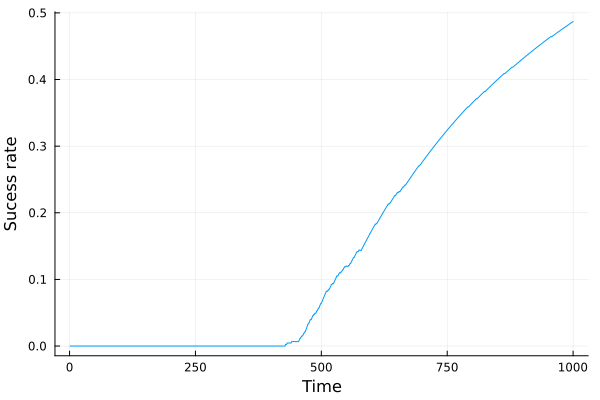

In [14]:
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)

<b> Plot 2: </b> Reward as a function of time.

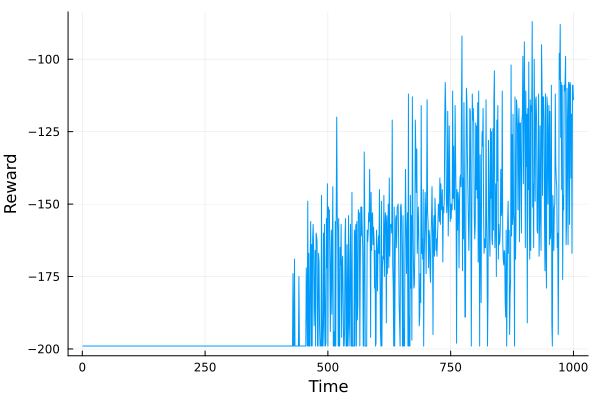

In [15]:
plot(rewards, xlabel = "Time", ylabel = "Reward", legend = false)

<b> Plot 3: </b> Value function surface.

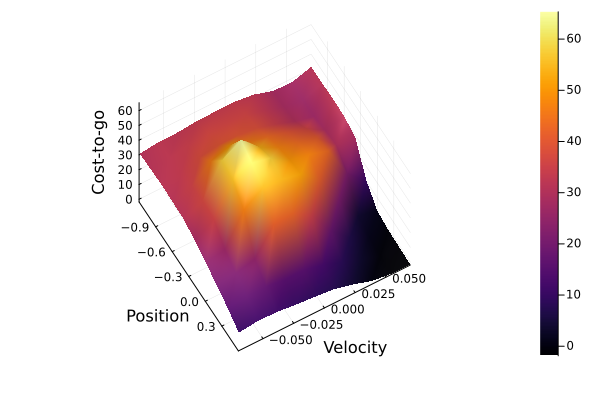

In [16]:
X = range(state_space(agent.env).a[1], state_space(agent.env).b[1], length = 10)
Y = range(state_space(agent.env).a[2], state_space(agent.env).b[2], length = 10)
Z = [maximum((agent.brain.net([x,y]))) for x in X, y in Y];

plot(X,Y,-Z, st=:surface, camera = (60,60), xlabel = "Position", ylabel = "Velocity", zlabel = "Cost-to-go")

<b> Plot 4: </b> Successe rate as a function of time in validation mode.

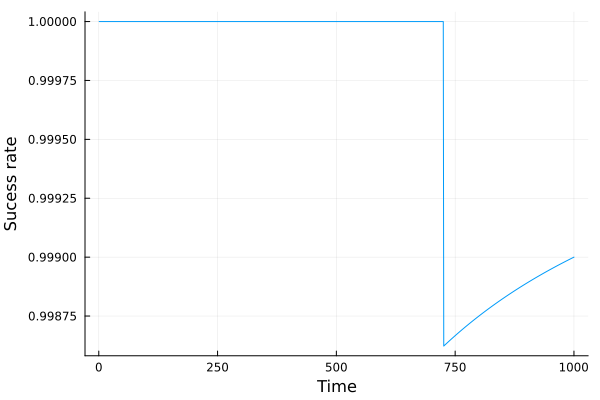

In [17]:
rewards,success_rates = run!(agent,1000; train = false, plotting = false, summary = false);
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)